## Thermal finite-element analysis for the BLAST CubeSat

This notebook shows how to use all modules in this repo for a reasonable preliminary on-orbit thermal analysis. 

We'll use a much more interesting (but still very simple) model of the sat. This one has six elements, one for each face of the sat. The sat's mass is evenly distributed among the elements, except the GGB tip mass is fully localized on the GGB face. The specific heat capacities still assume most of the mass is Al 6061 (which is pretty accurate, especially since most of our electronics are encased in that), except again for the tip mass, which is filled with lead shot. The long faces have solar panels on them, the GGB face exposed surfaces are entirely aluminum, and the antenna face only has the antenna's FR4 PCB exposed. Each face is connected to four adjacent faces. The conduction coefficient could definitely use some refining and I'm eyeballing the contact area, but I tried to be conservative in the hopes that internal radiation, which is not accounted for here, will act as additional effective thermal conduction in equalizing the different components of the sat.

All in all, this model should be quite accurate at reflecting the temperature range the sat's solar panels will experience. It is less accurate for internals, since the internal heat load of elecrtonic components will vary, so real components may experience temperature extremes outside of what this model shows.

In [1]:
from constants import *
from lumped_mass import *
from orbit import *
from rotation_sim import *
#from plotting import *
import plotting
import numpy as np
import scipy

## Sat model

In [2]:
def init_blast_model(
        ephem_path: str,
        R0: np.ndarray|None = None, 
        omega0: np.ndarray|None = None, 
        omega_mag: float|None = np.radians(1),
) -> tuple[list[ConnectedLumpedMass], Body, Orbit]:
    """Create lumped masses, a Body, and an Orbit to represent the BLAST CubeSat
    
    Creates an SGP4Orbit with ISS TLEs. Must specify ephem_path to point to ephemeris.

    Uses six ConnectedLumpedMasses, one for each face.

    R0 can be optionally used to specify the starting body orientation in the inertial (stationary) frame.
        Randomized if not specified.
    omega0 can be optionally used to specify the starting body angular velocity in the body (rotating) frame.
        Randomized if not specified (with magnitude equal to omega_mag, default 1 deg/s).
    """
    orbit = SGP4Orbit(
        *ISS_TLE, 
        ephem_path,
        t_tol=10
    )

    long_side_elt_dict = {
        'm': (CUBESAT_MASS-CUBESAT_TIP_MASS)/5,
        'A_rad': 10*u.cm*20*u.cm,
        'a': SOLAR_PANEL_ABSORPTANCE,
        'e': SOLAR_PANEL_EMISSIVITY,
        'q_int': CUBESAT_POWER_CONSUMPTION/5,
        'store_history': True
    }

    elts = [ # long faces
        ConnectedLumpedMass(
            body_normal = np.array(normal),
            **long_side_elt_dict,
        )
    for normal in [[1,0,0], [0,1,0], [-1,0,0], [0,-1,0]]]

    elts.append(ConnectedLumpedMass( # GGB square face
        body_normal = np.array([0,0,-1]),
        m= (CUBESAT_MASS-CUBESAT_TIP_MASS)/10 + CUBESAT_TIP_MASS,
        c= PB_SPEC_HEAT_CAP,
        A_rad= 10*u.cm*10*u.cm + CUBESAT_TIP_MASS_EXT_AREA,
        a= AL_ABSORPTANCE,
        e= AL_EMISSIVITY,
        q_int= CUBESAT_POWER_CONSUMPTION/10,
        store_history = True
    ))
    elts.append(ConnectedLumpedMass( # antenna square face
        body_normal = np.array([0,0,1]),
        m= (CUBESAT_MASS-CUBESAT_TIP_MASS)/10,
        A_rad= 10*u.cm*10*u.cm,
        a= FR4_ABSORPTANCE,
        e= FR4_EMISSIVITY,
        q_int= CUBESAT_POWER_CONSUMPTION/10,
        store_history = True
    ))

    for i,long_face in enumerate(elts[:4]):
        # Each long face connects to both of the square faces
        long_face.connect(elts[4], K = AL_HEAT_CONDUCTIVITY * 2*u.cm * 10*u.cm)
        long_face.connect(elts[5], K = AL_HEAT_CONDUCTIVITY * 2*u.cm * 10*u.cm)
        # Each long face connects to two adjacent long faces,
        # but since connect is bidirectional, only call it on the next face
        long_face.connect(elts[(i+1)%4], K = AL_HEAT_CONDUCTIVITY * 2*u.cm * 20*u.cm)

    if omega0 is None:
        random_omega = np.random.normal(size=3)
        omega0 = random_omega * omega_mag/np.linalg.norm(random_omega) 
    if R0 is None:
        random_bodyR = scipy.stats.special_ortho_group.rvs(3)
        R0 = random_bodyR
    body = Body(
        np.diag([CUBESAT_ROTI_XY.to(u.kg*u.m**2).magnitude, CUBESAT_ROTI_XY.to(u.kg*u.m**2).magnitude, CUBESAT_ROTI_Z.to(u.kg*u.m**2).magnitude]),
        R0 = R0,
        omega0=omega0
    )

    return elts, body, orbit

## Propagator

In [3]:
def eval_funct(t: float, state_vec: np.ndarray, t0: pd.Timestamp, elts: list[LumpedMass], body: Body, orbit: Orbit) -> np.ndarray:
    """Derivative function
    
    State vector convention: shape (9 + 3 + len(Body.elts)) in the order:
        R, omega, T

    Calculates Tdot for Body.elts using temperatures from y and orbital state from orbit,
    and calculates rotation matrix and angular velocity vector derivatives for Body.
    """ 
    body_R = state_vec[:9].reshape(3,3)
    body_omega = state_vec[9:12]
    T_vec = state_vec[12:]

    orbit.set_input(t0+pd.Timedelta(seconds=t))
    q_solar_normal, q_earth_normal = orbit.get_sun_earth_normal_power()
    r_earth, r_sun = orbit.get_earth_sun_vecs()

    body.set_input(body_R, body_omega)
    Rdot, omegadot = body.get_derivs()

    for T, elt in zip(T_vec, elts):
        elt.set_input(t, T, r_earth=r_earth, r_sun=r_sun, body_R=body_R, q_solar_normal=q_solar_normal, q_earth_normal=q_earth_normal)
    Tdot_vec = np.array([elt.find_Tdot() for elt in elts])

    return np.concat([Rdot.flatten(), omegadot, Tdot_vec])

def propagate_thermal_fem(
    elts: list[LumpedMass], body: Body, orbit: Orbit, 
    t_start: pd.Timestamp, duration: pd.Timedelta, t_step: pd.Timedelta,
    **kwargs
):
    y0 = np.concatenate((body.R.flatten(), body.omega, np.array([elt.T for elt in elts])))
    return scipy.integrate.solve_ivp(
        eval_funct, 
        (0, duration.total_seconds()), 
        y0, 
        args=(t_start, elts, body, orbit),
        t_eval = np.arange(0,duration.total_seconds(),t_step.total_seconds()),
        **kwargs
    )
    


""" def propagate_thermal_fem(
        elts: list[LumpedMass], body: Body, orbit: Orbit, 
        t_start: pd.Timestamp, duration: pd.Timedelta, t_step: pd.Timedelta,
        **kwargs
):
    ""Propagate FEM with attitude, orbital position, and temperature.
    
    The numerical itegrator will be interrupted every t_step
    to reorthonormalize the body rotation martix
    and print a rudimentary progress log (since solve_ivp doesn't offer callbacks).
    ""
    ts = []; ys = []; total_nfev = 0
    t= 0 # relative to start_t in sec
    y = np.concatenate((body.R.flatten(), body.omega, np.array([elt.T for elt in elts])))

    while t < duration.total_seconds():
        res = scipy.integrate.solve_ivp(
            eval_funct, 
            (t, t+t_step.total_seconds()), 
            y, 
            args=(t_start, body, orbit),
            **kwargs
        )
        assert res.status == 0
        ts.extend(res.t); ys.extend([res.y[:,i] for i in range(res.y.shape[1])]); total_nfev += res.nfev
        
        # Reorthonormalize rotation matrix
        body_R = res.y[:9, -1].reshape(3,3)
        body_R_corrected = reorthonormalize(body_R)

        t= res.t[-1]
        y = np.concatenate((body_R_corrected.flatten(), res.y[9:, -1]))

        if np.isclose(t % 100, 0): 
            print(f"{t} / {duration.total_seconds()}, nfev: {total_nfev}")
            total_nfev = 0

    return ts, ys
"""

' def propagate_thermal_fem(\n        elts: list[LumpedMass], body: Body, orbit: Orbit, \n        t_start: pd.Timestamp, duration: pd.Timedelta, t_step: pd.Timedelta,\n        **kwargs\n):\n    ""Propagate FEM with attitude, orbital position, and temperature.\n\n    The numerical itegrator will be interrupted every t_step\n    to reorthonormalize the body rotation martix\n    and print a rudimentary progress log (since solve_ivp doesn\'t offer callbacks).\n    ""\n    ts = []; ys = []; total_nfev = 0\n    t= 0 # relative to start_t in sec\n    y = np.concatenate((body.R.flatten(), body.omega, np.array([elt.T for elt in elts])))\n\n    while t < duration.total_seconds():\n        res = scipy.integrate.solve_ivp(\n            eval_funct, \n            (t, t+t_step.total_seconds()), \n            y, \n            args=(t_start, body, orbit),\n            **kwargs\n        )\n        assert res.status == 0\n        ts.extend(res.t); ys.extend([res.y[:,i] for i in range(res.y.shape[1])]); t

In [ ]:
elts, body, orbit = init_blast_model(
    'excerpt_de440.bsp',
    R0=np.eye(3), omega0=np.array([0,0,np.radians(5)]),
    )
#elt_names = [f"SP{i}" for i in range(1, 5)] + ["GGB", "Ant"]

In [5]:
sol = propagate_thermal_fem(
    elts, body, orbit,
    pd.Timestamp.now(), pd.Timedelta(minutes=1), pd.Timedelta(seconds=1)
)

In [6]:
sol.y[12:, :].shape

(6, 60)

In [19]:
from importlib import reload
reload(plotting)


<module 'plotting' from 'e:\\S-278\\repos\\YUAA_CubeSat_TFEM\\plotting.py'>

(<Figure size 1200x1200 with 12 Axes>,
 array([[<Axes: title={'center': 'Element 1'}, ylabel='T (K)'>,
         <Axes: title={'center': 'Element 2'}>],
        [<Axes: title={'center': 'Element 3'}, ylabel='T (K)'>,
         <Axes: title={'center': 'Element 4'}>],
        [<Axes: title={'center': 'Element 5'}, xlabel='Time', ylabel='T (K)'>,
         <Axes: title={'center': 'Element 6'}, xlabel='Time'>]],
       dtype=object))

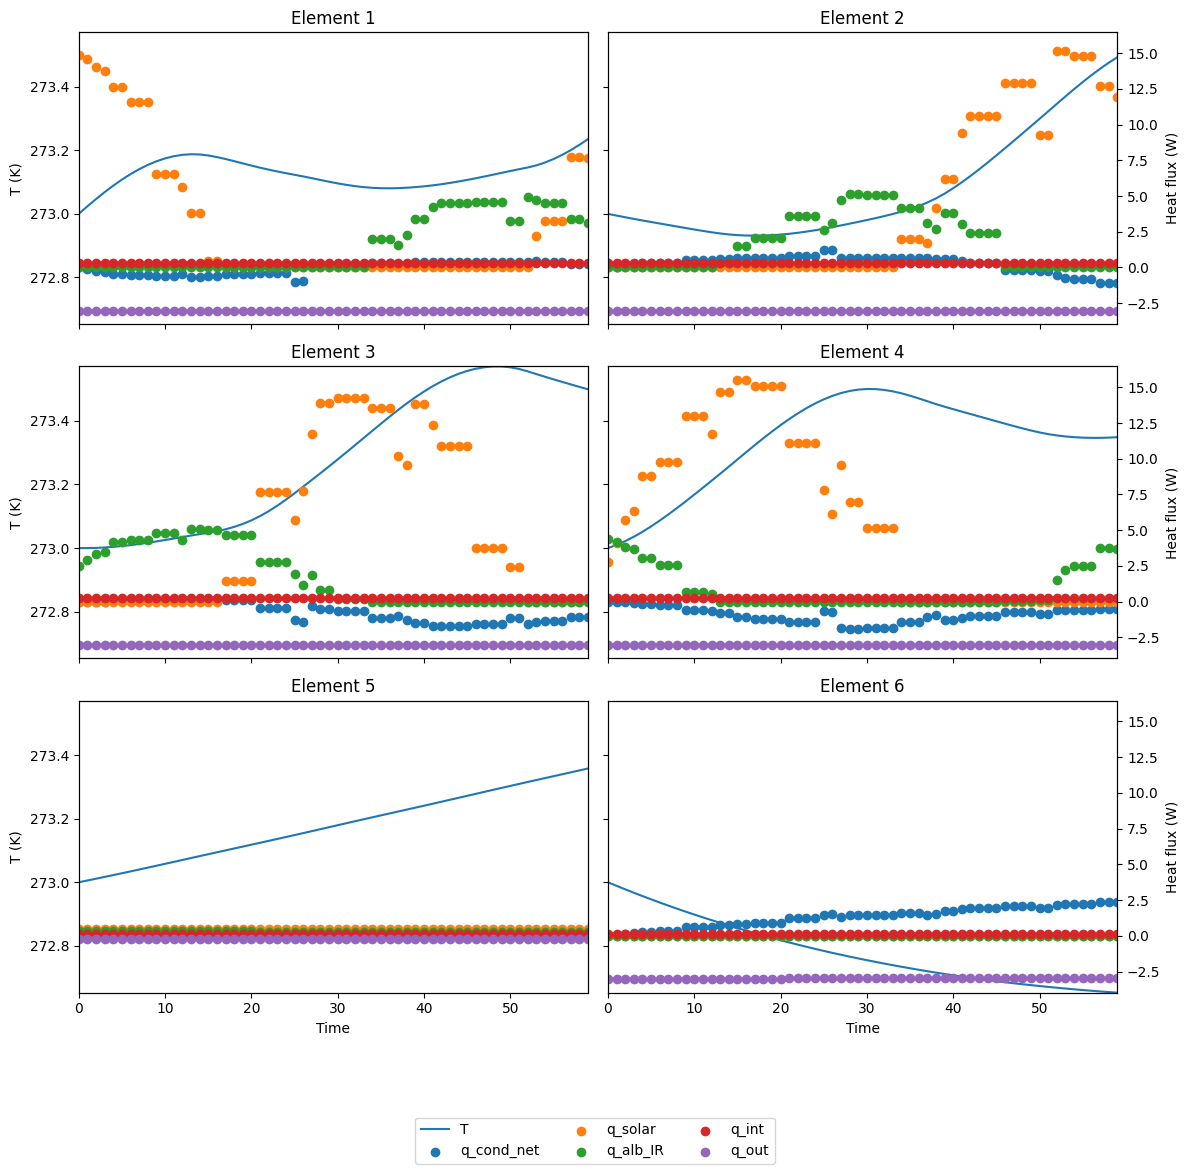

In [ ]:
plotting.plot_elts_T_q_flows(sol.t, sol.y[12:, :], elts)

In [12]:
q_flows = elts[4].get_history(sol.t).filter(like='q_')

In [13]:
q_flows

,q_cond_net,q_solar,q_alb_IR,q_int,q_out
t,,,,,
0.000000,0.000000,0.501076,0.316479,0.14486,-0.199832
1.049060,0.005029,0.501076,0.316479,0.14486,-0.199849
2.328401,0.012710,0.501076,0.316479,0.14486,-0.199870
2.840138,0.016867,0.501076,0.316479,0.14486,-0.199879
4.866316,0.032058,0.501076,0.316479,0.14486,-0.199912
4.866316,0.032058,0.501076,0.316479,0.14486,-0.199912
5.879405,0.043192,0.501076,0.316479,0.14486,-0.199930
5.879405,0.043192,0.501076,0.316479,0.14486,-0.199930
5.879405,0.043192,0.501076,0.316479,0.14486,-0.199930


<Axes: xlabel='Time', ylabel='T (K)'>

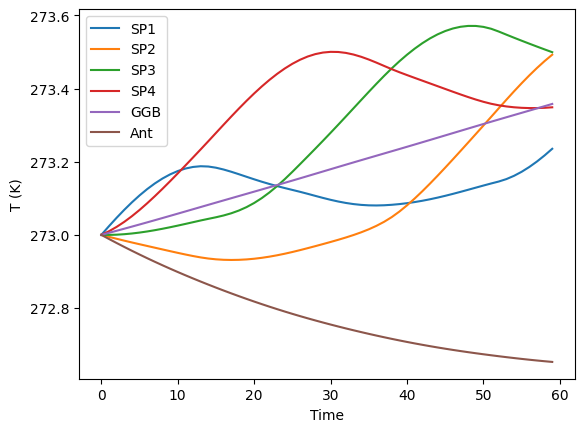

In [20]:
elt_names = [f"SP{i}" for i in range(1, 5)] + ["GGB", "Ant"]
plotting.plot_elts_Ts(sol.t, sol.y, elt_names=elt_names)

In [21]:
elts, body, orbit = init_blast_model(
    'excerpt_de440.bsp', omega_mag=np.radians(0.1),
)

In [22]:
sol = propagate_thermal_fem(
    elts, body, orbit,
    pd.Timestamp.now(), pd.Timedelta(minutes=90*10), pd.Timedelta(seconds=10)
)

(<Figure size 1200x1200 with 12 Axes>,
 array([[<Axes: title={'center': 'Element 0'}, ylabel='T (K)'>,
         <Axes: title={'center': 'Element 1'}>],
        [<Axes: title={'center': 'Element 2'}, ylabel='T (K)'>,
         <Axes: title={'center': 'Element 3'}>],
        [<Axes: title={'center': 'Element 4'}, xlabel='Time', ylabel='T (K)'>,
         <Axes: title={'center': 'Element 5'}, xlabel='Time'>]],
       dtype=object))

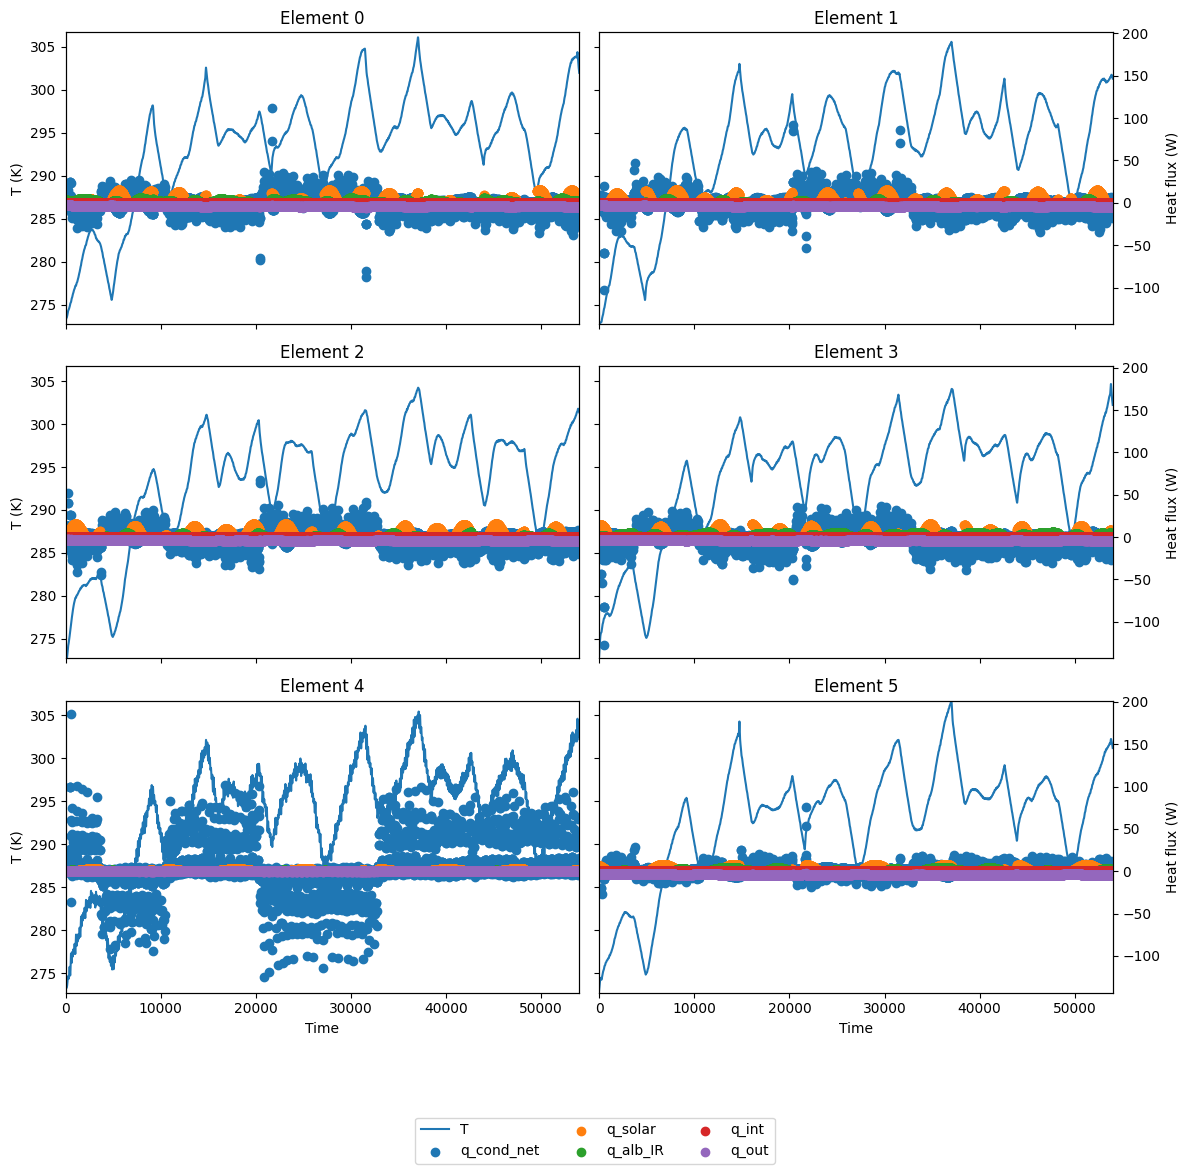

In [23]:
plotting.plot_elts_T_q_flows(sol.t, sol.y[12:, :], elts)

<Axes: xlabel='Time (orbital periods)', ylabel='T (K)'>

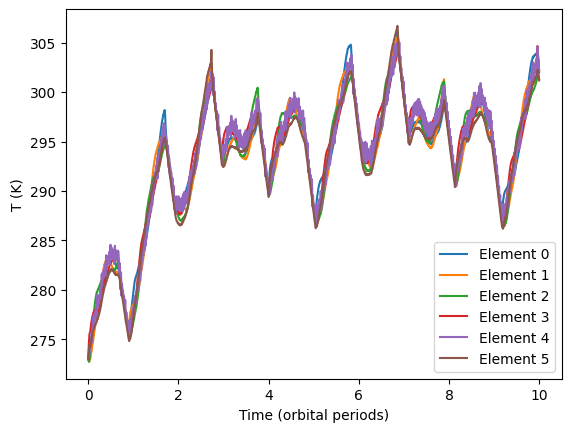

In [24]:
plotting.plot_elts_Ts(sol.t, sol.y, orbital_period=90*60)